In [10]:
import matplotlib.pyplot as plt
from torchvision import utils
from basic_fcn import *
from dataloader import *
from utils import *
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import time
import math
import pickle
import numpy as np
from tqdm import tqdm
import gc

In [2]:
f = open('baseline.log', 'r')

train_losses = []
val_losses = []
train_losses_epoch = []

for line in [x.rstrip('\n') for x in f.readlines()]:
    temp = line.split()
    if temp[0].startswith('epoch'):
        if len(temp) == 19: # Validation
            val_losses.append(temp[9])
            train_losses_epoch.append(temp[6])
        elif len(temp) == 4:
            train_losses.append(temp[3])
            
train_losses = [float(x) for x in train_losses]
val_losses = [float(x.rstrip(',')) for x in val_losses]
train_losses_epoch = [float(x.rstrip(',')) for x in train_losses_epoch]
            
print(len(train_losses))
print(len(val_losses))
print(val_losses)
print(train_losses[:10])

FileNotFoundError: [Errno 2] No such file or directory: 'baseline.log'

In [ ]:
plt.plot(train_losses)
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.show()

plt.plot(val_losses)
plt.xlabel('epoch')
plt.ylabel('val loss')
plt.show()

plt.plot(train_losses_epoch)
plt.xlabel('epoch')
plt.ylabel('train loss per epoch')
plt.show()

In [2]:
def val(model, val_loader, criterion, use_gpu):
    
    # set to evaluation mode 
    model.eval()

    softmax = nn.Softmax(dim = 1)
    
    loss = []
    pred = []
    acc = []
    
    IOU_init = False
    if use_gpu:
        device = torch.device("cuda:0")
        
        #model.to(device)
        
#     for iter, (X, tar, Y) in tqdm(enumerate(val_loader)):
    count = 0
    for iter, (X, tar, Y) in enumerate(val_loader):
        
        if not IOU_init:
            IOU_init = True
            IOU = np.zeros((1,19))
            
        if use_gpu:
            inputs = X.to(device)
            labels = Y.to(device)
            
        else:
            inputs, labels = X, Y

            
        with torch.no_grad():   
            outputs = model(inputs)    
            loss.append(criterion(outputs, labels.long()).item())
            prediction = softmax(outputs) 
#             print('pred shape: ', prediction.shape)
#             print('labels shape: ', labels.shape)
#             acc.append(pixel_acc(prediction, labels).item())
            acc.append(pixel_acc(prediction, labels))
            IOU = IOU + np.array(iou(prediction, labels))
            
        if iter % 100 == 0:
            print('iter: ', iter)
#         count += 1
#         if count == 7:
#             break
        
#     print(iter)
    acc = sum(acc)/len(acc)
    avg_loss = sum(loss)/len(loss) 
    IOU = IOU/iter  
    
    return avg_loss, acc, IOU      

In [3]:
train_dataset = CityScapesDataset(csv_file='train.csv')
val_dataset = CityScapesDataset(csv_file='val.csv')
train_loader = DataLoader(dataset=train_dataset,
                      batch_size=2,
                      num_workers=4,
                      shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                      batch_size=2,
                      num_workers=4,
                      shuffle=True)

criterion = torch.nn.CrossEntropyLoss()
use_gpu = torch.cuda.is_available()
print('use gpu: ', use_gpu)

val_losses = []
val_accs = []
val_ious = []

use gpu:  True


In [4]:
for epoch in range(27):
    fcn_model = torch.load('weights_baseline/epoch-{}'.format(epoch))
    
    val_loss, val_acc, val_iou = val(fcn_model, val_loader, criterion, use_gpu)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_ious.append(val_iou)
    print('epoch {} done'.format(epoch))
#     print('iou shape: ', val_iou.shape)
#     print(val_loss, val_acc, val_iou)

(19,)
iter:  0
(19,)
(19,)
(19,)
(19,)
(19,)
(19,)
(19,)
(19,)
(19,)
(19,)
(19,)
(19,)
(19,)
(19,)
(19,)
(19,)


KeyboardInterrupt: 

In [9]:
to_save = {}
to_save['val_accs'] = val_accs
to_save['val_losses'] = val_losses
to_save['val_ious'] = val_ious

pickle.dump(to_save, open('val_stats.pkl', 'wb'))

[55.49338932037354, 68.51301870346069, 71.15557928085327, 71.82049713134765, 74.96293067932129, 74.91591968536378, 76.26115865707398, 78.49598350524903, 78.62611036300659, 79.8488205909729, 81.01106271743774, 81.40178747177124, 81.81879453659057, 81.67829895019531, 82.27137107849121, 82.3140097618103, 82.10966081619263, 82.0537356376648, 83.03013830184936, 82.6362193107605, 83.31261348724365, 82.46640911102295, 83.32848243713379, 82.78832521438599, 82.87316207885742, 83.36629161834716, 82.85327529907227]


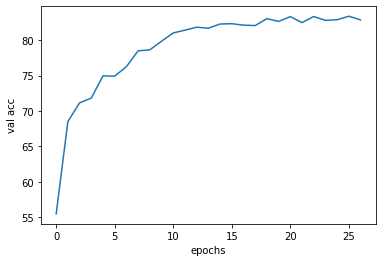

[0.6430594237925172, 0.7084697616079937, 0.7392475181933545, 0.7238359939581904, 0.7651136452612195, 0.7664608567458283, 0.7735230518291215, 0.8073639512741696, 0.8177111345233959, 0.8179471797649281, 0.8314621017566683, 0.8317849506515502, 0.8418329913565485, 0.842088452726063, 0.8467905849139191, 0.8468059356681789, 0.846299545617504, 0.8489332903693986, 0.8563744852633208, 0.8445446620243535, 0.8585683381217983, 0.8500359560608174, 0.8533916229612463, 0.8562016318635052, 0.8429559337477149, 0.8588583036975754, 0.8587757121586838]
Overall average iou:  0.8140161857744284


In [14]:
v = pickle.load(open('val_stats.pkl', 'rb'))
val_accs = v['val_accs']
val_ious = v['val_ious']

print(val_accs)
plt.plot(val_accs)
plt.xlabel('epochs')
plt.ylabel('val acc')
plt.show()

max_class_ious = []
for iou in val_ious:
#     print(iou.shape)
    
    iou = iou[~np.isnan(iou)]
    
    max_class_ious.append(np.max(iou))
    
print(max_class_ious)
print('Overall average iou: ', np.average(np.array(max_class_ious)))